### 0. Imports and Variable Setup

In [ ]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
from functions import util
import os
import hopsworks

country="sweden"
city = "solna"
street = "solna-rasundavagen-107"
aqicn_url="https://api.waqi.info/feed/@13988"

In [ ]:

# Get the API key from GitHub Secrets
HOPSWORKS_API_KEY = os.getenv('HOPSWORKS_API_KEY')

In [4]:
# Connect to Hopsworks Project and Features Store
project = hopsworks.login(project="ID2223LAB1KTH")
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1170583
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

## 4. Batch Inference

In [6]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today = today.replace(hour=0, minute=0, second=0, microsecond=0)

today

datetime.datetime(2024, 11, 16, 0, 0)

In [7]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

In [8]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [9]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.554429E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
weather_fg = fs.get_feature_group(
    name='stockholm_weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.81s) 


,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2024-11-20 00:00:00+00:00,3.3500,0.6500,31.400002,31.845251,59.193398
1,2024-11-17 00:00:00+00:00,7.5175,5.0175,0.100000,32.760002,253.447357
2,2024-11-19 00:00:00+00:00,1.4000,-1.4000,0.000000,10.144082,159.749298
3,2024-11-18 00:00:00+00:00,4.5675,-1.3000,0.000000,20.880001,272.388306
4,2024-11-16 00:00:00+00:00,11.9675,6.2675,0.100000,37.439999,248.332733
5,2024-11-21 00:00:00+00:00,3.3000,0.4500,6.399999,26.758923,202.746887
6,2024-11-22 00:00:00+00:00,0.4500,-2.7000,0.600000,19.862083,237.036652


In [11]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_max','temperature_2m_min','precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,predicted_pm25
0,2024-11-20 00:00:00+00:00,3.3500,0.6500,31.400002,31.845251,59.193398,23.399591
1,2024-11-17 00:00:00+00:00,7.5175,5.0175,0.100000,32.760002,253.447357,16.482494
2,2024-11-19 00:00:00+00:00,1.4000,-1.4000,0.000000,10.144082,159.749298,30.400328
3,2024-11-18 00:00:00+00:00,4.5675,-1.3000,0.000000,20.880001,272.388306,12.183895
4,2024-11-16 00:00:00+00:00,11.9675,6.2675,0.100000,37.439999,248.332733,15.359566
5,2024-11-21 00:00:00+00:00,3.3000,0.4500,6.399999,26.758923,202.746887,19.594934
6,2024-11-22 00:00:00+00:00,0.4500,-2.7000,0.600000,19.862083,237.036652,20.037609


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         7 non-null      datetime64[us, UTC]
 1   temperature_2m_max           7 non-null      float32            
 2   temperature_2m_min           7 non-null      float32            
 3   precipitation_sum            7 non-null      float32            
 4   wind_speed_10m_max           7 non-null      float32            
 5   wind_direction_10m_dominant  7 non-null      float32            
 6   predicted_pm25               7 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(6)
memory usage: 352.0 bytes


In [13]:
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data = batch_data.sort_values(by=['date'])
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.drop(columns=['temperature_2m_max','temperature_2m_min','precipitation_sum','wind_speed_10m_max','wind_direction_10m_dominant'])
batch_data

,date,predicted_pm25,days_before_forecast_day
4,2024-11-16 00:00:00+00:00,15.359566,1
1,2024-11-17 00:00:00+00:00,16.482494,2
3,2024-11-18 00:00:00+00:00,12.183895,3
2,2024-11-19 00:00:00+00:00,30.400328,4
0,2024-11-20 00:00:00+00:00,23.399591,5
5,2024-11-21 00:00:00+00:00,19.594934,6
6,2024-11-22 00:00:00+00:00,20.037609,7


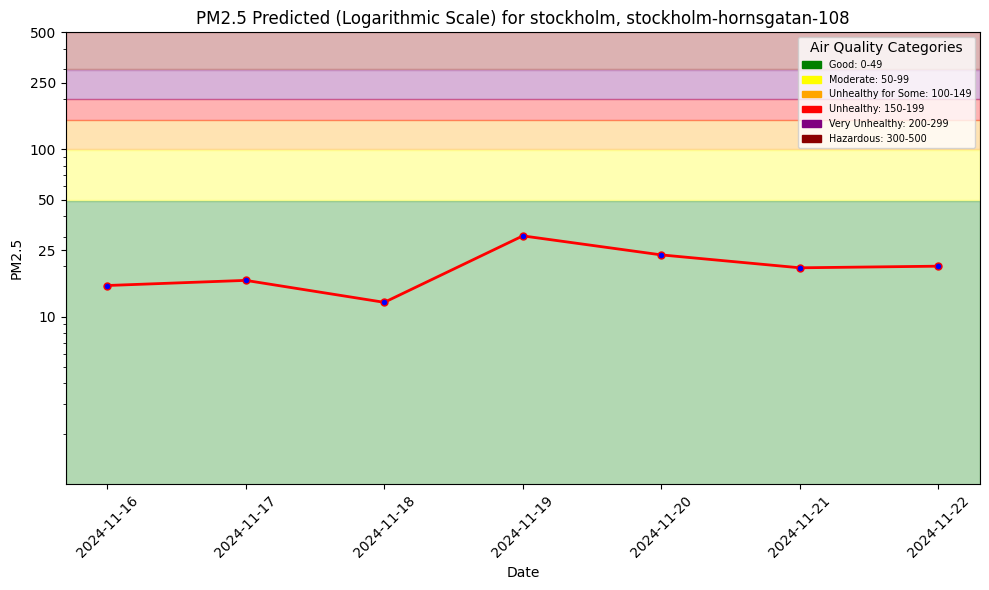

In [14]:
file_path = images_dir + "/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['date','days_before_forecast_day'],
    event_time="date"
)

In [16]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/7 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1170583/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7d1754e8c370>, None)

In [17]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day >= 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.05s) 


,date,predicted_pm25,days_before_forecast_day
0,2024-11-20 00:00:00+00:00,23.399591,5
1,2024-11-18 00:00:00+00:00,12.183895,3
2,2024-11-17 00:00:00+00:00,16.482494,2
3,2024-11-19 00:00:00+00:00,30.400328,4
4,2024-11-22 00:00:00+00:00,20.037609,7
5,2024-11-21 00:00:00+00:00,19.594934,6
6,2024-11-16 00:00:00+00:00,15.359566,1


In [18]:
air_quality_fg = fs.get_feature_group(
    name='stockholm_air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.53s) 


,date,pm25,pm10
0,2023-01-23 00:00:00+00:00,42,7
1,2023-05-27 00:00:00+00:00,16,23
2,2019-09-24 00:00:00+00:00,10,9
3,2018-06-14 00:00:00+00:00,20,23
4,2019-11-17 00:00:00+00:00,40,19
...,...,...,...
2559,2024-11-19 00:00:00+00:00,14,10
2560,2024-11-18 00:00:00+00:00,3,4
2561,2024-11-16 00:00:00+00:00,4,3
2562,2024-11-20 00:00:00+00:00,3,2


In [19]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
5,2024-11-16 00:00:00+00:00,15.359566,4
2,2024-11-17 00:00:00+00:00,16.482494,2
1,2024-11-18 00:00:00+00:00,12.183895,3
3,2024-11-19 00:00:00+00:00,30.400328,14
0,2024-11-20 00:00:00+00:00,23.399591,3
4,2024-11-21 00:00:00+00:00,19.594934,2


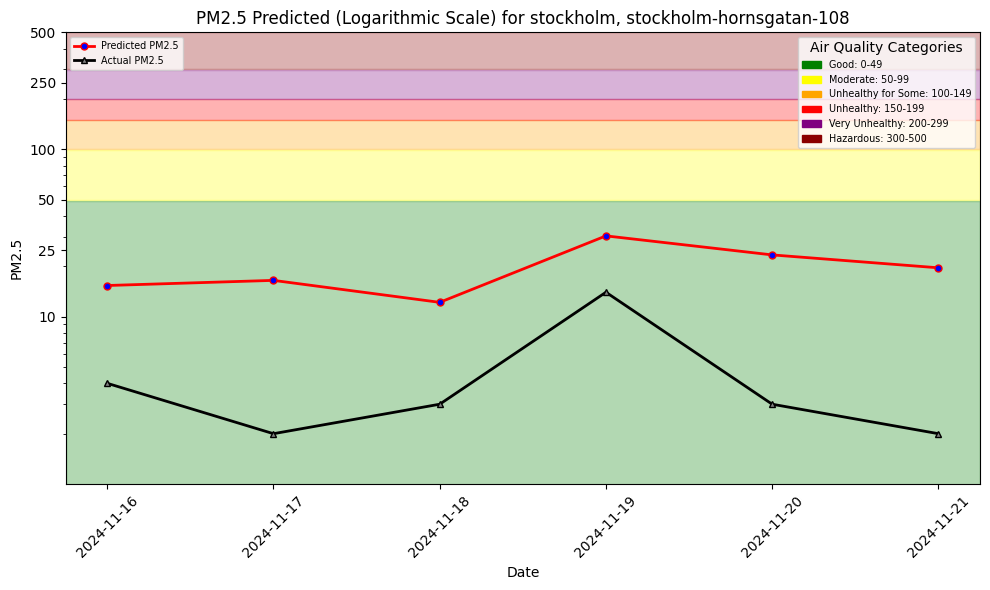

In [21]:

# Define the directory where you want to save the image
images_dir = "./dashboard"  # You can change this path as needed
os.makedirs(images_dir, exist_ok=True)  # Create the directory if it doesn't exist
# Save the figure to the images directory
file_path = os.path.join(images_dir, "pm25_hindcast_5_days.png")
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()